In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

## Loading images

In [ ]:
!unzip "/content/bald.zip" -d "/content/output_bald/"

In [ ]:
!unzip "/content/hair.zip" -d "/content/output_hair/"

# Remove Dodgy images

In [ ]:
extensions = ["png","jpg","jpeg","bmp"]

In [ ]:
data_dir = "/content/data"
os.listdir(data_dir)

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    img = cv2.imread(image_path)
    extension = imghdr.what(image_path)
    if extension not in extensions:
      os.remove(image_path)

# Load Data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 708 files belonging to 2 classes.


In [ ]:
#create the iterator for each batch
data_iterator = data.as_numpy_iterator()

In [ ]:
#get the next batch
batch = data_iterator.next()

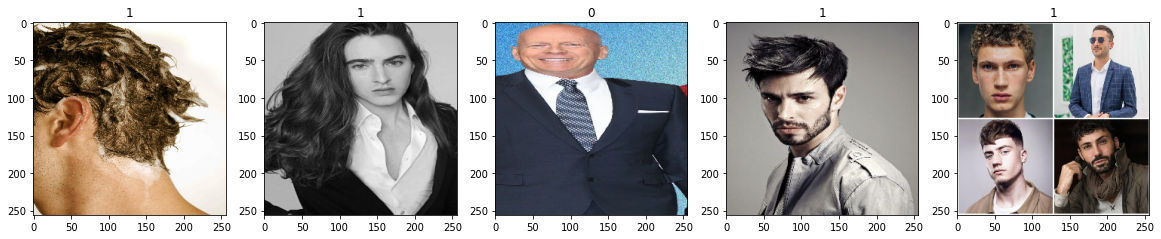

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Scale data

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, Dropout, MaxPooling2D

In [ ]:
model = Sequential()

In [ ]:
#256 x 256 x 3
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#254 x 254 x 16
model.add(MaxPooling2D()) 
#127 x 127 x 16

model.add(Conv2D(32, (3,3), 1, activation='relu'))
#125 x 125 x 32
model.add(MaxPooling2D())
#62 x 62 x 32

model.add(Conv2D(16, (3,3), 1, activation='relu'))
#60 x 60 x 16
model.add(MaxPooling2D())
#30 x 30 x 16

model.add(Flatten())
#14400

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Train the model

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
16/16 [==============================] - 24s 537ms/step - loss: 0.7128 - accuracy: 0.5508 - val_loss: 0.6320 - val_accuracy: 0.5688
Epoch 2/20
16/16 [==============================] - 11s 554ms/step - loss: 0.4966 - accuracy: 0.7578 - val_loss: 0.4008 - val_accuracy: 0.8125
Epoch 3/20
16/16 [==============================] - 11s 551ms/step - loss: 0.3233 - accuracy: 0.8672 - val_loss: 0.3584 - val_accuracy: 0.8313
Epoch 4/20
16/16 [==============================] - 11s 550ms/step - loss: 0.2794 - accuracy: 0.8887 - val_loss: 0.3015 - val_accuracy: 0.8813
Epoch 5/20
16/16 [==============================] - 11s 552ms/step - loss: 0.2741 - accuracy: 0.8965 - val_loss: 0.2381 - val_accuracy: 0.8875
Epoch 6/20
16/16 [==============================] - 16s 888ms/step - loss: 0.2083 - accuracy: 0.9238 - val_loss: 0.1677 - val_accuracy: 0.9375
Epoch 7/20
16/16 [==============================] - 11s 557ms/step - loss: 0.1482 - accuracy: 0.9434 - val_loss: 0.1229 - val_accuracy: 0.9500

## Test

In [ ]:
img = cv2.imread('/content/images/20.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

In [ ]:

if yhat > 0.5: 
    print(f'Predicted class is hair')
else:
    print(f'Predicted class is bald')

# Save and load the model

In [ ]:
model.save(os.path.join('models','baldOrNot.h5'))

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('baldOrNot.h5')